**Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones**
Edición 2021

# Aprendizaje No Supervisado
    Laura Alonso Alemany, Ana Georgina Flesia y Valeria Rulloni

---
## Trabajo práctico entregable

### Integrantes
- Bosch, Daniela
- Gherra, Estefanía
- Iberra, Yanina
- Mantovani, Luciano
- Palacio Pastor, Natalí

<center>
## Agrupamiento con el FIFA 2019 dataset

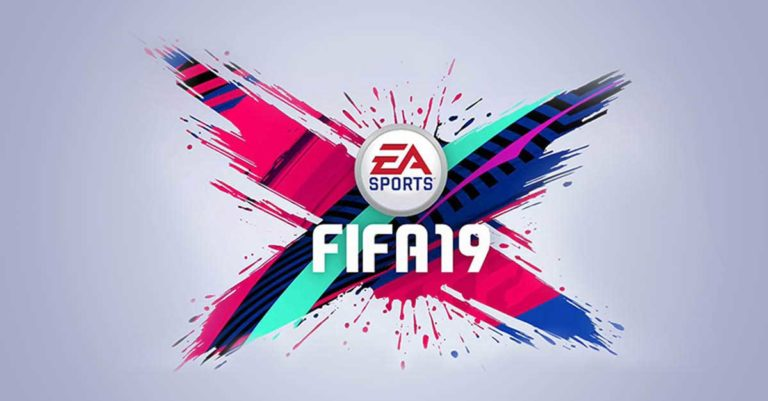
    
Material basado en notas de Ana Georgina Flesia bajo los términos y condiciones de la licencia [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/), a su vez basado de material de [SilveMel](https://www.kaggle.com/karangadiya/fifa19/downloads/data.csv/comments) y otros.

## Introducción

En este trabajo se busca encontrar aglomeraciones sobre el conjunto de datos de personajes del juego FIFA 2021. Este dataset resulta interesante para el análisis ya que cada jugador tiene muchas características a explorar, haciendo necesarias las técnicas de embedding y de feature engineering para visualizar y optimizar los algoritmos de clusterización.

Además se intentarán interpretar estos resultados relacionando estos clusters encontrados con características del dataset.

Debemos aclarar que ninguno de los integrantes de este equipo cuenta con expertise tanto en el dominio de los juegos FIFA como en el fútbol en general. Para avanzar con el trabajo se requirió de la colaboración de expertos en ambas áreas para lograr una mejor interpretabilidad.

## 0. Inicialización del entorno

**Empezamos cargando algunas herramientas para cargar los datos y manipularlos.**

In [1]:
import numpy as np
import pandas as pd
import itertools
import warnings
import io
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows',1000)

**Para visualización usaremos principalmente plotly, también seaborn y matplotlib.**

In [2]:
from plotly.offline import init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)
import matplotlib.pyplot as plt
import plotly.tools as tls#visualization
import plotly.figure_factory as ff#visualization
import seaborn as sns
import matplotlib.cm as cm
from sklearn.manifold import TSNE

**Librerias para Clustering**

In [3]:
from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth
from sklearn import decomposition
from sklearn.metrics import silhouette_samples, silhouette_score

## 1. Exploración de la base

Se utiliza la base de jugadores “players_21.csv” disponible en la página de Kaggle https://www.kaggle.com/stefanoleone992/fifa-21-complete-player-dataset?select=players_21.csv. 

In [4]:
df = pd.read_csv('https://raw.githubusercontent.com/Natali-PP/diplodatos2021/main/NoSupervisado/fifa-datasets/players_21.csv')
df.head()

,sofifa_id,player_url,short_name,long_name,age,dob,height_cm,weight_kg,nationality,club_name,league_name,league_rank,overall,potential,value_eur,wage_eur,player_positions,preferred_foot,international_reputation,weak_foot,skill_moves,work_rate,body_type,real_face,release_clause_eur,player_tags,team_position,team_jersey_number,loaned_from,joined,contract_valid_until,nation_position,nation_jersey_number,pace,shooting,passing,dribbling,defending,physic,gk_diving,gk_handling,gk_kicking,gk_reflexes,gk_speed,gk_positioning,player_traits,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,...,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,ls,st,rs,lw,lf,cf,rf,rw,lam,cam,ram,lm,lcm,cm,rcm,rm,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb
0,158023,https://sofifa.com/player/158023/lionel-messi/...,L. Messi,Lionel Andrés Messi Cuccittini,33,1987-06-24,170,72,Argentina,FC Barcelona,Spain Primera Division,1.0,93,93,67500000,560000,"RW, ST, CF",Left,5,4,4,Medium/Low,Messi,Yes,138400000.0,"#Dribbler, #Distance Shooter, #FK Specialist, ...",CAM,10.0,NaN,2004-07-01,2021.0,RW,10.0,85.0,92.0,91.0,95.0,38.0,65.0,NaN,NaN,NaN,NaN,NaN,NaN,"Finesse Shot, Long Shot Taker (AI), Speed Drib...",85,95,70,91,...,91,80,91,94,95,86,68,72,69,94,44,40,93,95,75,96,NaN,35,24,6,11,15,14,8,89+3,89+3,89+3,92+0,93+0,93+0,93+0,92+0,93+0,93+0,93+0,91+2,87+3,87+3,87+3,91+2,66+3,65+3,65+3,65+3,66+3,62+3,52+3,52+3,52+3,62+3
1,20801,https://sofifa.com/player/20801/c-ronaldo-dos-...,Cristiano Ronaldo,Cristiano Ronaldo dos Santos Aveiro,35,1985-02-05,187,83,Portugal,Juventus,Italian Serie A,1.0,92,92,46000000,220000,"ST, LW",Right,5,4,5,High/Low,C. Ronaldo,Yes,75900000.0,"#Aerial Threat, #Dribbler, #Distance Shooter, ...",LS,7.0,NaN,2018-07-10,2022.0,LS,7.0,89.0,93.0,81.0,89.0,35.0,77.0,NaN,NaN,NaN,NaN,NaN,NaN,"Power Free-Kick, Flair, Long Shot Taker (AI), ...",84,95,90,82,...,87,91,87,95,71,94,95,84,78,93,63,29,95,82,84,95,NaN,32,24,7,11,15,14,11,91+1,91+1,91+1,89+0,91+0,91+0,91+0,89+0,88+3,88+3,88+3,88+3,81+3,81+3,81+3,88+3,65+3,61+3,61+3,61+3,65+3,61+3,54+3,54+3,54+3,61+3
2,200389,https://sofifa.com/player/200389/jan-oblak/210002,J. Oblak,Jan Oblak,27,1993-01-07,188,87,Slovenia,Atlético Madrid,Spain Primera Division,1.0,91,93,75000000,125000,GK,Right,3,3,1,Medium/Medium,PLAYER_BODY_TYPE_259,Yes,159400000.0,NaN,GK,13.0,NaN,2014-07-16,2023.0,GK,1.0,NaN,NaN,NaN,NaN,NaN,NaN,87.0,92.0,78.0,90.0,52.0,90.0,"GK Long Throw, Comes For Crosses",13,11,15,43,...,43,60,67,88,49,59,78,41,78,12,34,19,11,65,11,68,NaN,12,18,87,92,78,90,90,33+3,33+3,33+3,32+0,35+0,35+0,35+0,32+0,38+3,38+3,38+3,35+3,38+3,38+3,38+3,35+3,32+3,36+3,36+3,36+3,32+3,32+3,33+3,33+3,33+3,32+3
3,188545,https://sofifa.com/player/188545/robert-lewand...,R. Lewandowski,Robert Lewandowski,31,1988-08-21,184,80,Poland,FC Bayern München,German 1. Bundesliga,1.0,91,91,80000000,240000,ST,Right,4,4,4,High/Medium,PLAYER_BODY_TYPE_276,Yes,132000000.0,"#Distance Shooter, #Clinical Finisher",ST,9.0,NaN,2014-07-01,2023.0,NaN,NaN,78.0,91.0,78.0,85.0,43.0,82.0,NaN,NaN,NaN,NaN,NaN,NaN,"Solid Player, Finesse Shot, Outside Foot Shot,...",71,94,85,84,...,77,78,77,93,82,89,84,76,86,85,81,49,94,79,88,88,NaN,42,19,15,6,12,8,10,89+2,89+2,89+2,85+0,87+0,87+0,87+0,85+0,85+3,85+3,85+3,83+3,79+3,79+3,79+3,83+3,64+3,65+3,65+3,65+3,64+3,61+3,60+3,60+3,60+3,61+3
4,190871,https://sofifa.com/player/190871/neymar-da-sil...,Neymar Jr,Neymar da Silva Santos Júnior,28,1992-02-05,175,68,Brazil,Paris Saint-Germain,French Ligue 1,1.0,91,91,90000000,270000,"LW, CAM",Right,5,5,5,High/Medium,Neymar,Yes,166500000.0,"

In [5]:
print(df.shape)

(18944, 106)


### Observaciones iniciales

- La variable `overall` se calcula usando otras variables de desempeño del jugador (skills_ratings). Es discreta, así como las otras de desempeño según habilidad, tomando valores enteros entre 0 y 100.
- Existen valores faltantes en algunas de estas habilidades.
- Las columnas `ls`, `st` y siguientes contienen un puntaje base y puntos adicionales que el jugador puede ganar respecto a una posición. La misma se encuentra de la forma 00+0, siendo el primer valor el puntaje base y el segundo, el puntaje extra.


### Mejores jugadores en general

Miramos ahora los mejores jugadores por posicion, usando las variables `overall` y `team_position`. Realizamos el histograma de la variable `overall` (Desempeño global).

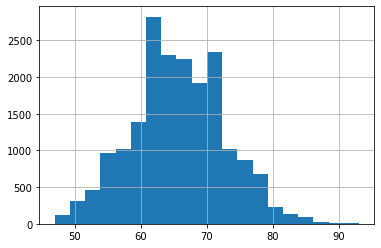

In [6]:
df['overall'].hist(bins = 20)

### Mejores jugadores por posición

Observamos los mejores jugadores por posición en el equipo mirando las variables `team_position` y el `overall`.

In [7]:
df.iloc[df.groupby(df['team_position'])['overall'].idxmax()][['team_position','short_name','overall']]

,team_position,short_name,overall
0,CAM,L. Messi,93
55,CB,M. Hummels,86
17,CDM,Casemiro,89
15,CF,K. Benzema,89
355,CM,I. Fernández,81
2,GK,J. Oblak,91
378,LAM,C. Nkunku,80
33,LB,A. Robertson,87
8,LCB,V. van Dijk,90
24,LCM,T. Kroos,88


### Conteos por posiciones.

Observamos cuántos jugadores hay en cada posición de equipo.

In [8]:
pd.DataFrame(df['team_position'].value_counts().sort_index())

,team_position
CAM,286
CB,128
CDM,181
CF,13
CM,76
GK,681
LAM,25
LB,553
LCB,681
LCM,425


### Mejor puntaje promedio por club

Observamos la variable `overall` en conjunto con la variable `club_name`.

In [9]:
df.groupby("club_name")["overall"].mean().reset_index().sort_values("overall",ascending=False).head(10)

,club_name,overall
216,FC Bayern München,81.045455
489,Real Madrid,79.250000
131,Chelsea,79.212121
214,FC Barcelona,78.909091
374,Liverpool,78.575758
330,Inter,78.000000
387,Manchester United,77.818182
386,Manchester City,77.484848
339,Juventus,77.483871
612,Tottenham Hotspur,77.242424


### Mejor puntaje promedio por liga

Liga de futbol con el overall promedio mas alto

In [10]:
df.groupby("league_name")["overall"].mean().reset_index().sort_values("overall",ascending=False).head(10)

,league_name,overall
16,English Premier League,73.107034
42,Spain Primera Division,72.782946
49,Ukrainian Premier League,72.285714
20,German 1. Bundesliga,71.662409
25,Italian Serie A,71.468217
5,Campeonato Brasileiro Série A,71.102778
10,Czech Republic Gambrinus Liga,70.746835
18,French Ligue 1,70.036667
38,Russian Premier League,69.913580
23,Greek Super League,69.446429


### Puntaje, edad y sueldo promedio por país

Promedio de `overall`, `age` y `wage_eur` por `nationality`, ordenados por cantidad de jugadores en el dataset.

In [11]:
groupedDF = df.groupby("nationality")["overall",'age','sofifa_id','wage_eur'].agg(
    overall_mean=pd.NamedAgg(column='overall', aggfunc='mean'),
    age_mean=pd.NamedAgg(column='age', aggfunc='mean'),
    cantidad = pd.NamedAgg(column='sofifa_id', aggfunc='count'),
    sueldo_mean = pd.NamedAgg(column='wage_eur', aggfunc='mean'),
).reset_index()

In [12]:
groupedDF.sort_values("cantidad",ascending=False).head(10)

,nationality,overall_mean,age_mean,cantidad,sueldo_mean
47,England,62.878338,23.987537,1685,9321.364985
58,Germany,65.689655,24.681245,1189,8932.253995
140,Spain,69.261194,25.601679,1072,14512.033582
54,France,67.175813,24.443089,984,13513.668699
6,Argentina,67.793803,26.232906,936,9685.309829
20,Brazil,70.961669,26.068771,887,14590.022548
79,Japan,64.586912,26.306748,489,3565.235174
107,Netherlands,67.458333,24.412037,432,10912.268519
76,Italy,68.707838,25.866983,421,15233.254157
155,United States,63.507937,24.603175,378,3714.814815


Hay más cantidad de jugadores de Europa seguidos por Sudamérica. Llama la atención que hay más japoneses que italianos, siendo que este país en el inconsciente colectivo tiene más trayectoria en el fútbol (mundiales, clubes élite y copas europea).

### Mejor puntaje promedio por nacionalidad

Ahora realizamos el mismo cálculo pero ordenando por el overall promedio.

In [13]:
groupedDF.sort_values("overall_mean",ascending=False).head(10)

,nationality,overall_mean,age_mean,cantidad,sueldo_mean
146,Tanzania,76.000000,27.000000,1,55000.000000
28,Chad,73.000000,27.000000,1,15000.000000
105,Mozambique,72.200000,28.600000,5,13400.000000
17,Bermuda,72.000000,30.000000,1,33000.000000
7,Armenia,71.500000,28.000000,4,23500.000000
89,Libya,71.250000,26.500000,4,7250.000000
45,Egypt,71.172414,27.448276,29,15827.586207
124,Puerto Rico,71.000000,28.000000,1,6000.000000
108,New Caledonia,71.000000,32.000000,1,9000.000000
20,Brazil,70.961669,26.068771,887,14590.022548


Vemos que aquellas nacionalidades con puntaje alto quedaron en esa posición por la poca cantidad de jugadores que tienen, con un puntaje mayor a 70. Hay otras nacionalidades con jugadores que presentan overall mucho mayores, pero dado que tambien cuentan con muchos otros jugadores con overall bajo, en promedio terminan quedando en posiciones más bajas dentro de la tabla.

Mostramos el caso de Messi, con un overall de 93, y más abajo, el overall promedio de Argentina, que es mucho más bajo debido a que tiene 936 jugadores.

In [14]:
df[df.short_name == 'L. Messi']

,sofifa_id,player_url,short_name,long_name,age,dob,height_cm,weight_kg,nationality,club_name,league_name,league_rank,overall,potential,value_eur,wage_eur,player_positions,preferred_foot,international_reputation,weak_foot,skill_moves,work_rate,body_type,real_face,release_clause_eur,player_tags,team_position,team_jersey_number,loaned_from,joined,contract_valid_until,nation_position,nation_jersey_number,pace,shooting,passing,dribbling,defending,physic,gk_diving,gk_handling,gk_kicking,gk_reflexes,gk_speed,gk_positioning,player_traits,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,...,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,ls,st,rs,lw,lf,cf,rf,rw,lam,cam,ram,lm,lcm,cm,rcm,rm,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb
0,158023,https://sofifa.com/player/158023/lionel-messi/...,L. Messi,Lionel Andrés Messi Cuccittini,33,1987-06-24,170,72,Argentina,FC Barcelona,Spain Primera Division,1.0,93,93,67500000,560000,"RW, ST, CF",Left,5,4,4,Medium/Low,Messi,Yes,138400000.0,"#Dribbler, #Distance Shooter, #FK Specialist, ...",CAM,10.0,NaN,2004-07-01,2021.0,RW,10.0,85.0,92.0,91.0,95.0,38.0,65.0,NaN,NaN,NaN,NaN,NaN,NaN,"Finesse Shot, Long Shot Taker (AI), Speed Drib...",85,95,70,91,...,91,80,91,94,95,86,68,72,69,94,44,40,93,95,75,96,NaN,35,24,6,11,15,14,8,89+3,89+3,89+3,92+0,93+0,93+0,93+0,92+0,93+0,93+0,93+0,91+2,87+3,87+3,87+3,91+2,66+3,65+3,65+3,65+3,66+3,62+3,52+3,52+3,52+3,62+3


In [15]:
groupedDF[groupedDF['nationality'] == 'Argentina']

,nationality,overall_mean,age_mean,cantidad,sueldo_mean
6,Argentina,67.793803,26.232906,936,9685.309829


### Relación entre edad y salario

Exploramos las variables edad y salario

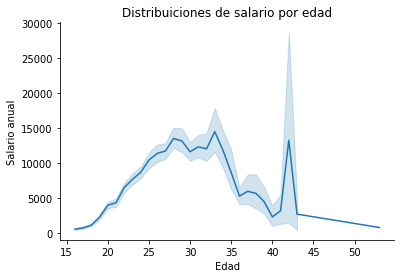

In [16]:
ax = sns.lineplot(data=df, x="age", y="wage_eur")
ax.set_title("Distribuiciones de salario por edad")
ax.set_ylabel("Salario anual")
ax.set_xlabel("Edad")
sns.despine()

Podemos ver que hay dos picos en la distribución.


A medida que aumenta la edad, crece el sueldo promedio hasta los 27 años aproximadamente, en donde parece mantenerse estable, para luego empezar a bajar alrededor de los 33 años. Se observa un pico en los 42, 43 años y luego la distribución vuelve a decrecer para terminar de llegar a valores cercanos a cero. Creemos que la separación podría deberse la separación entre arqueros y no arqueros ya que los primeros suelen tener carreras más largas que el resto de los jugadores.

## 2. Preparación de los datos

Debemos separar los puntajes sobre las posiciones en puntaje base, puntaje extra y la suma de éstos. Por conocimiento del dominio creemos que los jugadores nuevos suelen tener un puntaje extra más alto ya que pueden ganar más experiencia.

In [17]:
# A partir de esta columna realizamos la curación de los datos de este tipo
score_position_cols = df.columns[df.columns.get_loc('ls'):]

# Generamos tres columnas
for c in score_position_cols:
    df[[c+'_base', c+'_extra']] = df[c].str.split('+', expand=True)
    df[c+'_base'] = pd.to_numeric(df[c+'_base'], errors="coerce").fillna(0).astype(int)
    df[c+'_extra'] = pd.to_numeric(df[c+'_extra'], errors="coerce").fillna(0).astype(int)
    df[c+'_full'] = df[c+'_base'] + df[c+'_extra']

df.head()

,sofifa_id,player_url,short_name,long_name,age,dob,height_cm,weight_kg,nationality,club_name,league_name,league_rank,overall,potential,value_eur,wage_eur,player_positions,preferred_foot,international_reputation,weak_foot,skill_moves,work_rate,body_type,real_face,release_clause_eur,player_tags,team_position,team_jersey_number,loaned_from,joined,contract_valid_until,nation_position,nation_jersey_number,pace,shooting,passing,dribbling,defending,physic,gk_diving,gk_handling,gk_kicking,gk_reflexes,gk_speed,gk_positioning,player_traits,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,...,cam_extra,cam_full,ram_base,ram_extra,ram_full,lm_base,lm_extra,lm_full,lcm_base,lcm_extra,lcm_full,cm_base,cm_extra,cm_full,rcm_base,rcm_extra,rcm_full,rm_base,rm_extra,rm_full,lwb_base,lwb_extra,lwb_full,ldm_base,ldm_extra,ldm_full,cdm_base,cdm_extra,cdm_full,rdm_base,rdm_extra,rdm_full,rwb_base,rwb_extra,rwb_full,lb_base,lb_extra,lb_full,lcb_base,lcb_extra,lcb_full,cb_base,cb_extra,cb_full,rcb_base,rcb_extra,rcb_full,rb_base,rb_extra,rb_full
0,158023,https://sofifa.com/player/158023/lionel-messi/...,L. Messi,Lionel Andrés Messi Cuccittini,33,1987-06-24,170,72,Argentina,FC Barcelona,Spain Primera Division,1.0,93,93,67500000,560000,"RW, ST, CF",Left,5,4,4,Medium/Low,Messi,Yes,138400000.0,"#Dribbler, #Distance Shooter, #FK Specialist, ...",CAM,10.0,NaN,2004-07-01,2021.0,RW,10.0,85.0,92.0,91.0,95.0,38.0,65.0,NaN,NaN,NaN,NaN,NaN,NaN,"Finesse Shot, Long Shot Taker (AI), Speed Drib...",85,95,70,91,...,0,93,93,0,93,91,2,93,87,3,90,87,3,90,87,3,90,91,2,93,66,3,69,65,3,68,65,3,68,65,3,68,66,3,69,62,3,65,52,3,55,52,3,55,52,3,55,62,3,65
1,20801,https://sofifa.com/player/20801/c-ronaldo-dos-...,Cristiano Ronaldo,Cristiano Ronaldo dos Santos Aveiro,35,1985-02-05,187,83,Portugal,Juventus,Italian Serie A,1.0,92,92,46000000,220000,"ST, LW",Right,5,4,5,High/Low,C. Ronaldo,Yes,75900000.0,"#Aerial Threat, #Dribbler, #Distance Shooter, ...",LS,7.0,NaN,2018-07-10,2022.0,LS,7.0,89.0,93.0,81.0,89.0,35.0,77.0,NaN,NaN,NaN,NaN,NaN,NaN,"Power Free-Kick, Flair, Long Shot Taker (AI), ...",84,95,90,82,...,3,91,88,3,91,88,3,91,81,3,84,81,3,84,81,3,84,88,3,91,65,3,68,61,3,64,61,3,64,61,3,64,65,3,68,61,3,64,54,3,57,54,3,57,54,3,57,61,3,64
2,200389,https://sofifa.com/player/200389/jan-oblak/210002,J. Oblak,Jan Oblak,27,1993-01-07,188,87,Slovenia,Atlético Madrid,Spain Primera Division,1.0,91,93,75000000,125000,GK,Right,3,3,1,Medium/Medium,PLAYER_BODY_TYPE_259,Yes,159400000.0,NaN,GK,13.0,NaN,2014-07-16,2023.0,GK,1.0,NaN,NaN,NaN,NaN,NaN,NaN,87.0,92.0,78.0,90.0,52.0,90.0,"GK Long Throw, Comes For Crosses",13,11,15,43,...,3,41,38,3,41,35,3,38,38,3,41,38,3,41,38,3,41,35,3,38,32,3,35,36,3,39,36,3,39,36,3,39,32,3,35,32,3,35,33,3,36,33,3,36,33,3,36,32,3,35
3,188545,https://sofifa.com/player/188545/robert-lewand...,R. Lewandowski,Robert Lewandowski,31,1988-08-21,184,80,Poland,FC Bayern München,German 1. Bundesliga,1.0,91,91,80000000,240000,ST,Right,4,4,4,High/Medium,PLAYER_BODY_TYPE_276,Yes,132000000.0,"#Distance Shooter, #Clinical Finisher",ST,9.0,NaN,2014-07-01,2023.0,NaN,NaN,78.0,91.0,78.0,85.0,43.0,82.0,NaN,NaN,NaN,NaN,NaN,NaN,"Solid Player, Finesse Shot, Outside Foot Shot,...",71,94,85,84,...,3,88,85,3,88,83,3,86,79,3,82,79,3,82,79,3,82,83,3,86,64,3,67,65,3,68,65,3,68,65,3,68,64,3,67,61,3,64,60,3,63,60,3,63,60,3,63,61,3,64
4,190871,https://sofifa.com/player/190871/neymar-da-sil...,Neymar Jr,Neymar da Silva Santos Júnior,28,1992-02-05,175,68,Brazil,Paris Saint-Germain,French Ligue 1,1.0,91,91,90000000,270000,"LW, CAM",Right,5,5,5,High/Medium,Neymar,Yes,166500000.0,"#Speedster, #Dribbler, #Playmaker, #FK Special...",LW,10.0,NaN,2017-08-03,2022.0,NaN,NaN,91.0,85.0,86.0,94.0,36.0,59.0,NaN,NaN,NaN,NaN,NaN,NaN,"Injury Prone, Flair, Speed Dribbler (AI), Outs...",85,87,62,87,...,1,91,90,1,91,90,1,91,83,3,86,83,3,86,83,3,86,90,1,91,67,3,70,62,3,65,62,3,65,62,3,65,67,3,70,62,3,65,49,3,52,49,3,52,49,3,52,62,3,65


### Creación de nuevos features

Al contar con demasiados atributos para realizar la aglomeración, necesitamos crear nuevos features que describan las características principales de un jugador.

#### Sobre las habilidades

Debemos agrupar las diferentes habilidades en sus distintos tipos. Consideramos variables de desempeño por habilidad (`skills_ratings`).

Vemos que no todas las habilidades están relacionadas exclusivamente con ciertas posiciones.

Separamos las habilidades en tres grupos:
- `general_skills`: son las primeras 12 habilidades del listado, las cuales refieren a características generales del jugador.
- `specific_skills`: describen una caracteristica o tipo de pase, gol, aceleración, actitud, etc. dentro de una habilidad general. Resultan más interesantes para el análisis.
- `position_skills`: contiene las habilidades que, en la primera parte de su nombre, evidencian la posición del jugador a la que hacen referencia.

Además, se diferenciaron las habilidades de arqueros para los siguientes análisis.

In [18]:
general_skills = list(df.columns[df.columns.get_loc('pace'):df.columns.get_loc('gk_positioning')+1])
specific_skills = list(df.columns[df.columns.get_loc('attacking_crossing'):df.columns.get_loc('goalkeeping_reflexes')+1])
position_skills = [col for col in df.columns if '_full' in col or '_base' in col]
skills_ratings = general_skills + specific_skills + position_skills

goalkeeper_skills = [col for col in skills_ratings if 'gk_' in col]
non_goalkeeper_skills = [col for col in general_skills if col not in goalkeeper_skills]

In [19]:
general_skills[:5]

['pace', 'shooting', 'passing', 'dribbling', 'defending']

In [20]:
specific_skills[:5]

['attacking_crossing',
 'attacking_finishing',
 'attacking_heading_accuracy',
 'attacking_short_passing',
 'attacking_volleys']

In [21]:
position_skills[:5]

['ls_base', 'ls_full', 'st_base', 'st_full', 'rs_base']

#### Sobre su posición

Agrupamos las posiciones en 4 categorias: delanteros, mediocampistas, defensores y arqueros. Para esto tenemos varias columnas que nos ayudar a clasificarlos: `team_position`, `player_positions`, `nation_positions`. Utilizamos primero la columna `team_positions` ya que consideramos es la más representativa. Luego, como la misma contiene valores nulos, completamos la posición faltante con `player_positions`.

In [22]:
forward_player = ["ST", "LW", "RW", "LF", "RF", "RS","LS", "CF"]
midfielder_player = ["CM","RCM","LCM", "CDM","RDM","LDM", "CAM", "LAM", "RAM", "RM", "LM"]
defender_player = ["CB", "RCB", "LCB", "LWB", "RWB", "LB", "RB"]
df["position"] = "Desconocido"
# Arqueros
df.loc[df["team_position"] == "GK", "position"] = "Arquero"
# Defensores
df.loc[df["team_position"].isin(defender_player), "position"] = "Defensor"
# Mediocampistas
df.loc[df["team_position"].isin(midfielder_player), "position"] = "Mediocampista"
# Delanteros
df.loc[df["team_position"].isin(forward_player), "position"] = "Delantero"

# Arqueros
df.loc[(df["player_positions"] == "GK") & (df["position"] == "Desconocido"), "position"] = "Arquero"
# Defensores
df.loc[(df["player_positions"].isin(defender_player)) & (df["position"] == "Desconocido"), "position"] = "Defensor"
# Mediocampistas
df.loc[(df["player_positions"].isin(midfielder_player)) & (df["position"] == "Desconocido"), "position"] = "Mediocampista"
# Delanteros
df.loc[(df["player_positions"].isin(forward_player)) & (df["position"] == "Desconocido"), "position"] = "Delantero"

In [23]:
df["position"].value_counts(dropna=False)

Desconocido      5016
Defensor         4912
Mediocampista    4181
Delantero        2752
Arquero          2083
Name: position, dtype: int64

Hay 5016 casos que quedan momentaneamente fuera de la clasificación.

### Filtrado de filas
Retiramos jugadores con bajo desempeño global (`overall`) y reducimos el tamaño de la base. Consideramos que las diferencias en los grupos pueden observarse en los jugadores con puntajes altos.

In [24]:
# Consideramos jugadores con overall alto
df_n = df[(df['overall'] > 70)]
df_n.shape

(4512, 185)

Se crea ficticiamente al jugador "perfecto" para ver a dónde se ubica en nuestras visualizaciones, como punto de referencia.

In [25]:
MachineGunDict = { 'short_name': 'MachineGun', 'overall': 99 }
for skills in skills_ratings:
    MachineGunDict[skills] = 99
    
df_n = df_n.append(MachineGunDict, ignore_index=True)

In [26]:
# sólo con desempeños según habilidad (numéricas)
df_skills = df_n[skills_ratings]
df_skills.head()

,pace,shooting,passing,dribbling,defending,physic,gk_diving,gk_handling,gk_kicking,gk_reflexes,gk_speed,gk_positioning,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,ls_base,ls_full,st_base,st_full,rs_base,rs_full,lw_base,lw_full,lf_base,lf_full,cf_base,cf_full,rf_base,rf_full,rw_base,rw_full,lam_base,lam_full,cam_base,cam_full,ram_base,ram_full,lm_base,lm_full,lcm_base,lcm_full,cm_base,cm_full,rcm_base,rcm_full,rm_base,rm_full,lwb_base,lwb_full,ldm_base,ldm_full,cdm_base,cdm_full,rdm_base,rdm_full,rwb_base,rwb_full,lb_base,lb_full,lcb_base,lcb_full,cb_base,cb_full,rcb_base,rcb_full,rb_base,rb_full
0,85.0,92.0,91.0,95.0,38.0,65.0,NaN,NaN,NaN,NaN,NaN,NaN,85,95,70,91,88,96,93,94,91,96,91,80,91,94,95,86,68,72,69,94,44,40,93,95,75,96,NaN,35,24,6,11,15,14,8,89,92,89,92,89,92,92,92,93,93,93,93,93,93,92,92,93,93,93,93,93,93,91,93,87,90,87,90,87,90,91,93,66,69,65,68,65,68,65,68,66,69,62,65,52,55,52,55,52,55,62,65
1,89.0,93.0,81.0,89.0,35.0,77.0,NaN,NaN,NaN,NaN,NaN,NaN,84,95,90,82,86,88,81,76,77,92,87,91,87,95,71,94,95,84,78,93,63,29,95,82,84,95,NaN,32,24,7,11,15,14,11,91,92,91,92,91,92,89,89,91,91,91,91,91,91,89,89,88,91,88,91,88,91,88,91,81,84,81,84,81,84,88,91,65,68,61,64,61,64,61,64,65,68,61,64,54,57,54,57,54,57,61,64
2,NaN,NaN,NaN,NaN,NaN,NaN,87.0,92.0,78.0,90.0,52.0,90.0,13,11,15,43,13,12,13,14,40,30,43,60,67,88,49,59,78,41,78,12,34,19,11,65,11,68,NaN,12,18,87,92,78,90,90,33,36,33,36,33,36,32,32,35,35,35,35,35,35,32,32,38,41,38,41,38,41,35,38,38,41,38,41,38,41,35,38,32,35,36,39,36,39,36,39,32,35,32,35,33,36,33,36,33,36,32,35
3,78.0,91.0,78.0,85.0,43.0,82.0,NaN,NaN,NaN,NaN,NaN,NaN,71,94,85,84,89,85,79,85,70,88,77,78,77,93,82,89,84,76,86,85,81,49,94,79,88,88,NaN,42,19,15,6,12,8,10,89,91,89,91,89,91,85,85,87,87,87,87,87,87,85,85,85,88,85,88,85,88,83,86,79,82,79,82,79,82,83,86,64,67,65,68,65,68,65,68,64,67,61,64,60,63,60,63,60,63,61,64
4,91.0,85.0,86.0,94.0,36.0,59.0,NaN,NaN,NaN,NaN,NaN,NaN,85,87,62,87,87,95,88,89,81,95,94,89,96,91,83,80,62,81,50,84,51,36,87,90,92,93,NaN,30,29,9,9,15,15,11,84,87,84,87,84,87,90,90,89,89,89,89,89,89,90,90,90,91,90,91,90,91,90,91,83,86,83,86,83,86,90,91,67,70,62,65,62,65,62,65,67,70,62,65,49,52,49,52,49,52,62,65


In [27]:
# Diferenciamos a los mejores jugadores
bool_crack = df_n["overall"] > 85
len(df_n[bool_crack])

63

## 3. Evaluación visual e intuitiva de a dos variables por vez

En esta etapa buscamos agrupamiento de datos usando las variables en `skill_ratings` de a pares.

### Panorama general de variables

Para realizar la comparación de las variables, decidimos plotearlas en conjunto y así observarlas de una sola vez.

#### Habilidades generales

Observamos las relaciones entre todos los skills generales, excepto aquellos que son propios de los arqueros.

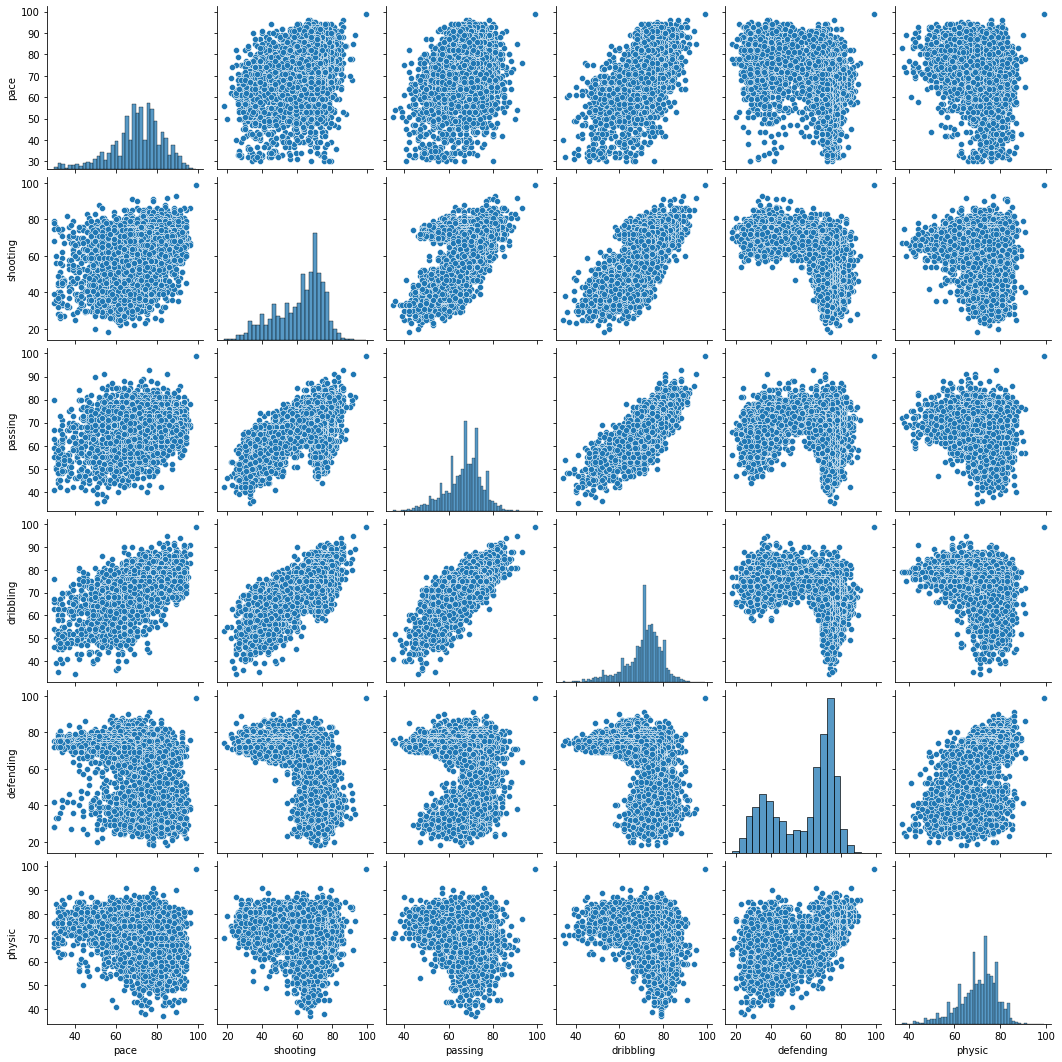

In [28]:
sns.pairplot(df_n[non_goalkeeper_skills])

##### Observaciones
- Se puede ver que se forman grupos para la mayoría de las combinaciones con la habilidad `defending`.
- La variable `shooting` también parece separarse levemente en dos grupos para algunas combinaciones.
- `dribbling` y `shooting`, `passing` y `shooting` parecen formar grupos.

#### Habilidades de arquero

Ahora vemos si existen algunas agrupaciones entre las habilidades generales de los arqueros.

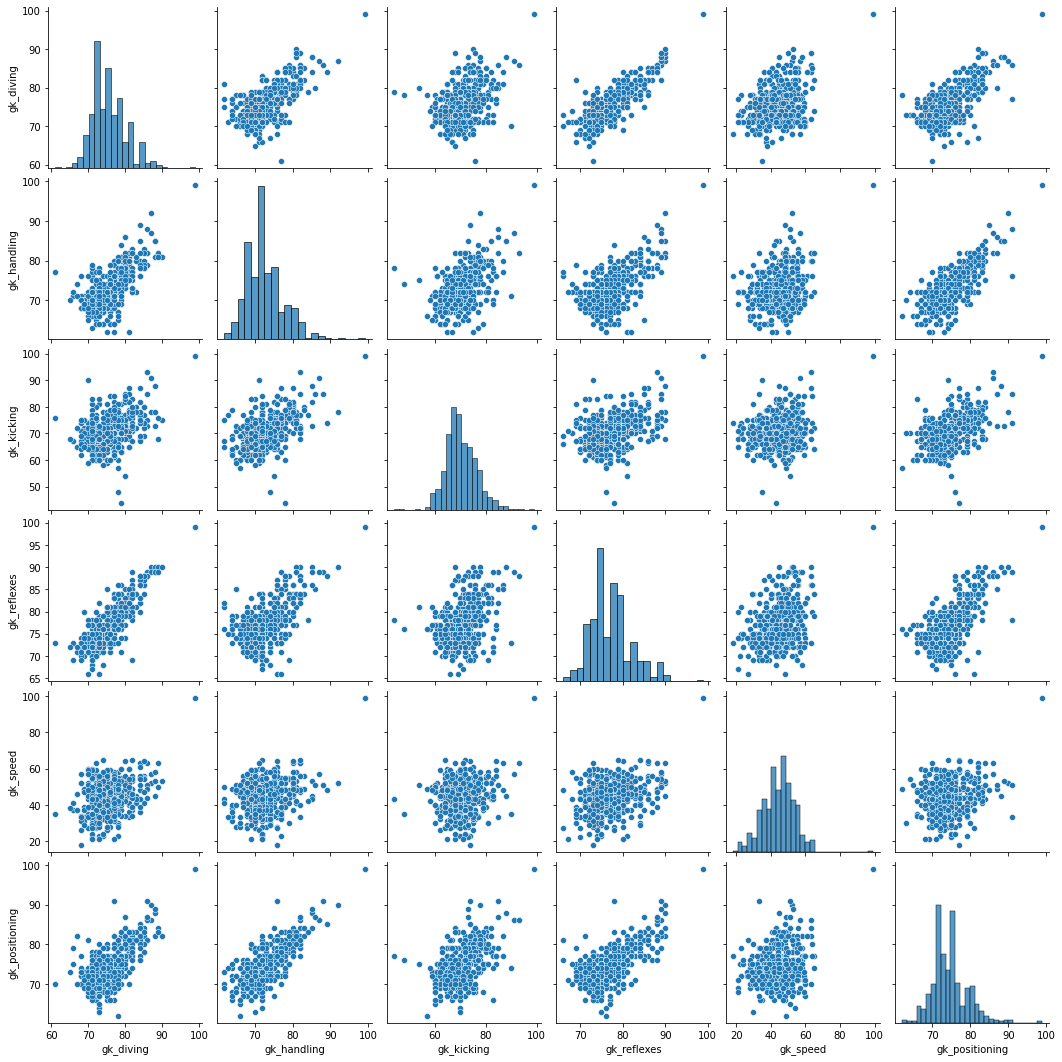

In [29]:
sns.pairplot(df_n[goalkeeper_skills])

##### Observaciones
- Las habilidades de arquero no parecen a simple vista formar clusters, como si se veia en el gráfico anterior.

#### Habilidades específicas

En el gráfico siguiente hacemos un pairplot entre todas las habilidades específicas (tanto de arqueros como no). No buscamos aquí analizar las relaciones entre las variables en detalle, sino intentar apreciar globalmente la formación o no de clusters.

A grandes rasgos, se observan muchos agrupamientos de a dos. Creemos que puede deberse a la separación entre arqueros y no arqueros.

In [30]:
sns.pairplot(df_n.query("position != 'Arquero'")[specific_skills])

Output hidden; open in https://colab.research.google.com to view.

##### Observaciones

- A grandes rasgos, se pueden ver algunos grupos para las habilidades `defending_standing_tackle`, `defending_sliding_tackle`, `mentality_interceptions`, `power_stamina`.
- No hay datos para la habilidad `defending_marking`.

### Variables seleccionadas

Ahora visualizamos algunos pares de variables, que seleccionamos para observarlas en forma más detallada y sumamos algunos skills no observados en los gráficos anteriores. Definimos una función para graficar con Plotly y otra para realizar una gráfica más liviana con matlotlib. En el gráfico más complejo (con Plotly), utilizamos a Messi y a nuestro jugador perfecto como referencia. En ambos casos comparamos a los jugadores con `overall` > 85.

In [31]:
def plot_with_plotly(skill_1, skill_2):
    all_players = go.Scatter(
        x=df_skills[skill_1], 
        y=df_skills[skill_2],
        mode='markers',
        text=df_n.loc[:,'club_name'],
        marker=dict(size=5)
    )

    goalk = go.Scatter(
        x=df_skills.loc[df_n["position"]=='Arquero',skill_1], 
        y=df_skills.loc[df_n["position"]=='Arquero',skill_2],
        name='Arqueros',
        text=df_n.loc[df_n["position"]=='Arquero','short_name'],
        mode='markers',
        marker=dict(color="lime")
    )

    cracks = go.Scatter(
        x=df_skills.loc[bool_crack,skill_1], 
        y=df_skills.loc[bool_crack,skill_2],
        name='Top players',
        text=df_n.loc[bool_crack,'short_name'],
        textfont=dict(family='sans serif', size=10, color='black'),
        opacity=0.9,
        mode='text+markers',
        marker=dict(color="crimson")
    )

    messi = go.Scatter(
        x=df_skills.loc[df_n["short_name"]=='L. Messi', skill_1], 
        y=df_skills.loc[df_n["short_name"]=='L. Messi', skill_2],
        name='Searched player',
        text='L. Messi',
        textfont=dict(family='sans serif',size=20,color='black'),
        opacity=1,
        marker=dict(size=40),
        mode='markers+text'
    )

    machinegun = go.Scatter(
        x=df_skills.loc[df_n["short_name"]=='MachineGun', skill_1], 
        y=df_skills.loc[df_n["short_name"]=='MachineGun', skill_2],
        name='Perfect player',
        textfont=dict(family='sans serif',size=20,color='black'),
        opacity=0.6,
        marker=dict(size=30),
        mode='markers+text'
    )

    data = [all_players, goalk, cracks, machinegun, messi]

    layout = go.Layout(
        title=f"Comparación entre {skill_1} y {skill_2}",
        titlefont=dict(size=20),
        xaxis=dict(title=skill_1),
        yaxis=dict(title=skill_2),
        autosize=False, 
        width=700,
        height=700
    )

    fig = go.Figure(data=data, layout=layout)
    # En Colab
    fig.show(renderer="colab")

def plot_with_matplotlib(skill_1, skill_2):
    plt.figure(figsize=(8,8))
    plt.scatter(df_skills[skill_1], y=df_skills[skill_2], s=10, c=bool_crack, cmap="coolwarm")
    plt.xlabel(skill_1)
    plt.ylabel(skill_2)
    plt.title(f"Comparación entre {skill_1} y {skill_2}")
    plt.show()

#### Defending vs Dribbling

In [32]:
plot_with_plotly('defending', 'dribbling')

##### Observaciones

- Se puede notar que los jugadores con puntaje mas alto (puntos rojos) suelen tener mayor dribbling. 
- Vemos que Messi se ubica en los valores altos de `dribbling` y valores bajos de `defending`, lo cual es esperado de acuerdo a su posición.
- Los arqueros parecen tener valores nulos en estas habilidades.

#### Mentality Interceptions vs Attacking Crossing

In [33]:
plot_with_plotly("mentality_interceptions", "attacking_crossing")

##### Observaciones
- En este caso se puede observar al grupo de arqueros y otros dos grupos más, algo que no sucedía en el gráfico anterior.

#### Shooting vs Mentality Agression


En próxima gráfica, similar a la anterior, también se diferencian los mejores jugadores (cracks) respecto a los que tienen overall < 86 (average). Por otro lado, se distinguen al mejor jugador ficticio "MachineGun", y a Messi. Todo esto para intentar observar visualmente y de forma bivariada si se encuentra algún clúster.

In [34]:
plot_with_plotly("mentality_aggression", "shooting")

##### Observaciones
- Los mejores jugadores (en rojo) tienen mejor shooting, pero están más distribuidos en relación al gráfico anterior donde se concentraban los mejores jugadores en dribbling. Por lo que se puede observar, no se ve una relación clara entre la agresividad y ser crack.

- Si bien no se pueden indentificar claramente clusters relacionados con las características analizadas (crack, no crack), sí podemos ver que los jugadores se concenran en dos grandes grupos separados por un dribbling de 60 aproximadamente. 

#### Defending vs Attacking Finishing

Seleccionamos `defending` y `attacking_finishing `como ejes para graficar ya que intuiamos que al ser habilidades con estrecha relacion a dos posiciones diferentes.

In [35]:
plot_with_plotly("attacking_finishing", "defending")

#### Observaciones
- Al no estar incluidos los arqueros, se pueden diferenciar dos grupos: El de arriba se diferencia claramente del de abajo, y deducimos que se trata de defensores y delanteros respectivamente. La zona del medio probablemente sean los mediocampistas.
- No se observa que los jugadores cracks se concentren en algún grupo, sino que están distribuídos dentro de las agrupaciones identificadas anteriormente. 

**Importante:** Por más que sea un gráfico bivariado, al haber seleccionado estas habilidades y haberlas observado con respecto a la posición, se puede tener una primera aproximación de los distintos clusters a encontrar.

## 4. Uso y análisis de técnicas de clustering: K-Medias, Mean Shift, Jerarquico

Utilizamos distintas técnicas de aglomeración sobre el dataset en base a lo explorado. 

Antes debemos completar los datos faltantes NaN para poder realizar los agrupamientos. Los mismos se completan con 0 ya que consideramos que el jugador no posee dicha habilidad si el valor es nulo.

In [36]:
df_n = df_n.fillna(0)

Eliminamos al juagador perfecto ya que sólo resultaba útil para las visualizaciones.

In [37]:
# Eliminar MachineGun
df_n = df_n[df_n['short_name'] != 'MachineGun']

Seleccionamos las skills observadas anteriormente.



In [38]:
selected_skills = [
    "defending", "shooting", "dribbling", "passing", 
    "defending_standing_tackle", "defending_sliding_tackle", 
    "mentality_interceptions", "power_stamina", "attacking_crossing",
    "attacking_finishing", "mentality_aggression"
]
X = df_n[selected_skills]

Separamos a los jugadores que no son arqueros para encontrar clusters más interesantes.

In [39]:
df_no_gk = df_n[df_n["position"] != 'Arquero']
no_gk = df_no_gk[selected_skills]

In [40]:
df_gk = df_n[df_n["position"] == 'Arquero']
gk = df_gk[selected_skills]

### Algoritmo de KMeans

El algoritmo de vecinos más cercanos parece ser correcto para encontrar clusters en los datos que observamos anteriormente. Utilizamos la distancia euclídea como métrica.

Buscamos el número de clusters óptimo observando la inercia de cada uno.

#### Todos los jugadores

Aglomeramos teniendo en cuenta a todos los jugadores, sin descartar a los arqueros.

Text(0.5, 1.0, 'Inertia of k-Means versus number of clusters')

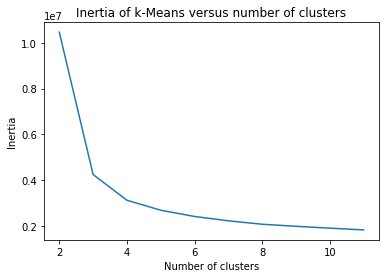

In [41]:
scores = [KMeans(n_clusters=i).fit(X).inertia_ for i in range(2,12)]

plt.plot(np.arange(2, 12), scores)
plt.xlabel('Number of clusters')
plt.ylabel("Inertia")
plt.title("Inertia of k-Means versus number of clusters")

Si bien existe un ángulo pronunciado con 3 clusters, creemos que el más adecuado es 4. A partir de este valor, la inercia se mantiene más estable pero con cambios menos abruptos que con menor cantidad de clusters.


#### Sin los arqueros

Ahora calculamos la inercia con el conjunto de datos sin los arqueros.

Text(0.5, 1.0, 'Inertia of k-Means versus number of clusters')

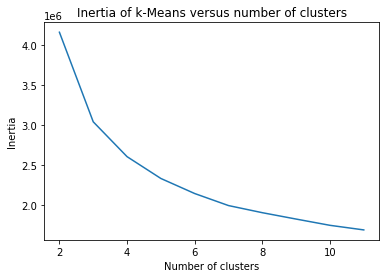

In [42]:
scores = [KMeans(n_clusters=i).fit(no_gk).inertia_ for i in range(2,12)]

plt.plot(np.arange(2, 12), scores)
plt.xlabel('Number of clusters')
plt.ylabel("Inertia")
plt.title("Inertia of k-Means versus number of clusters")

Con este gráfico  observamos que la cantidad óptima de clusters sin los arqueros es 3, un cluster menos que en el conjunto que contiene a los arqueros. 

Probamos K-means con los datos de todas las posiciones primero con 4 clusters.

In [43]:
# Número de clusters buscado
n_clust = 4

km_all_4 = KMeans(n_clusters=n_clust, random_state=22)
km_all_4.fit(X)

print('Inertia = ', km_all_4.inertia_)

Inertia =  3127866.686599211


Probamos K-means con los datos sin los arqueros con 3 clusters. Quitamos a los jugadores arqueros y los categorizamos como un solo grupo.

In [44]:
# Número de clusters buscado
n_clust = 3

km_no_gk_3 = KMeans(n_clusters=n_clust, random_state=22)
km_no_gk_3.fit(no_gk)

print('Inertia = ', km_no_gk_3.inertia_)

Inertia =  3043477.790458809


#### Analisis de silueta

Luego de realizar el aglomeramiento observamos algunas métricas. Como no es posible graficar todas las dimensiones, graficaremos con habilidades de a pares.

In [45]:
# Elegimos grupos de dos skills para poder graficar
skill_sets = [
    ["attacking_finishing", "defending"], 
    ["mentality_interceptions", "attacking_crossing"]
]

Definimos una función auxiliar para graficar la silueta de los clusters observándolos en el espacio con algunas habilidades.

In [46]:
def plot_silhouette(method, n_clust, cluster_labels, centers, X):
    for sset in skill_sets:
        skill_1 = sset[0]
        skill_2 = sset[1]

        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)

        ax1.set_xlim([-0.1, 1])
        ax1.set_ylim([0, len(X) + (n_clust + 1) * 10])

        silhouette_avg = silhouette_score(X, cluster_labels)
        print("Para n_clust =", n_clust, "El silhouette_score promedio es :", silhouette_avg)

        # Calculamos el score para cada sample
        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clust):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clust)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                                0, ith_cluster_silhouette_values,
                                facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("Visualización de los datos.")
        ax1.set_xlabel("Espacio de la primera característica")
        ax1.set_ylabel("Espacio de la segunda característica")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed
        colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clust)
        ax2.scatter(X.loc[:, skill_1].values, X.loc[:, skill_2].values, marker='.', s=30, lw=0, alpha=0.7,
                    c=colors, edgecolor='k')

        # Draw white circles at cluster centers
        ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                    c="white", alpha=1, s=200, edgecolor='k')

        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                        s=50, edgecolor='k')

        ax2.set_title("Visualización de los datos.")
        ax2.set_xlabel(skill_1)
        ax2.set_ylabel(skill_2)

        plt.suptitle((f"Análisis de silueta para {method} con n_clusters = {n_clust}"),
                        fontsize=14, fontweight='bold')

        plt.show()

Observamos la silueta para la aglomeración con 4 cuatro clusters, todos los jugadores.

In [47]:
n_clust = 4
cluster_labels = km_all_4.fit_predict(X)
centers = km_all_4.cluster_centers_

Para n_clust = 4 El silhouette_score promedio es : 0.4335752257551428


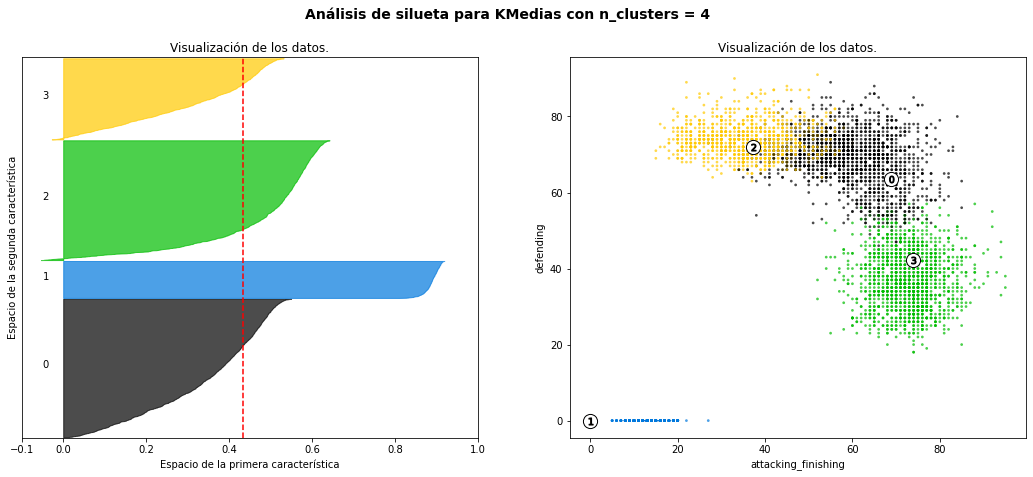

Para n_clust = 4 El silhouette_score promedio es : 0.4335752257551428


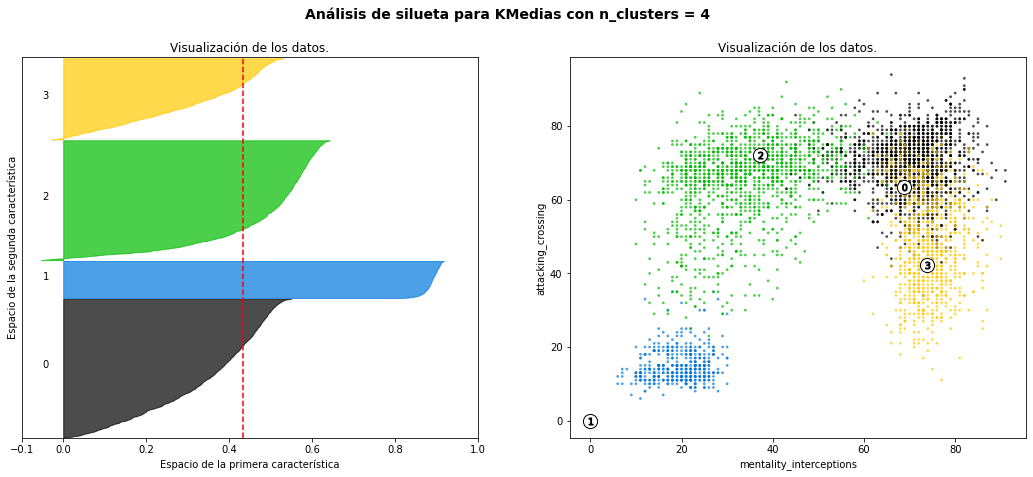

In [48]:
plot_silhouette("KMedias", n_clust, cluster_labels, centers, X)

In [49]:
# Cantidad de jugadores por clúster para el kmeans de todas las posiciones y 4 clústers
pd.value_counts(km_all_4.labels_)

0    1658
2    1437
3     973
1     444
dtype: int64

En los gráficos anteriores, se trabajó con 4 clústers pero se visualizan dos pares de variables diferentes. 
En el gráfico siguiente, visualizamos los mismos pares de variables, pero trabajando con 3 clústers. La idea de esto es determinar qué cantidad de grupos es más apropiada.

In [50]:
n_clust = 3
cluster_labels = km_no_gk_3.predict(no_gk)
centers = km_no_gk_3.cluster_centers_

Para n_clust = 3 El silhouette_score promedio es : 0.3840715294834027


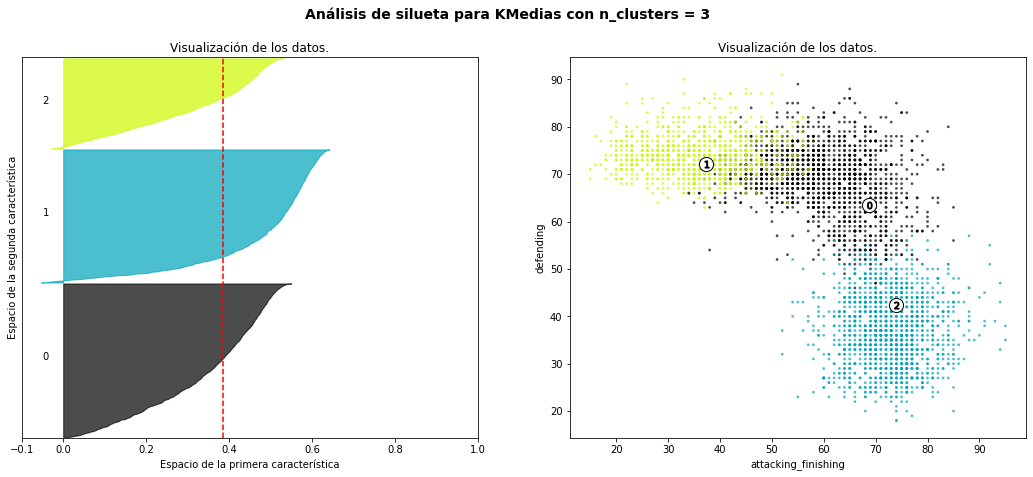

Para n_clust = 3 El silhouette_score promedio es : 0.3840715294834027


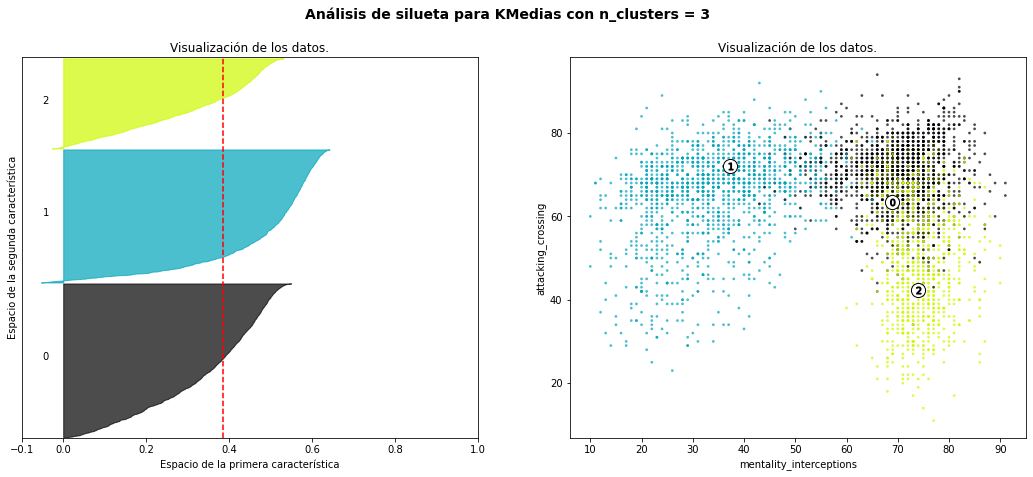

In [51]:
plot_silhouette("KMedias", n_clust, cluster_labels, centers, no_gk)

In [52]:
# Cantidad de jugadores por clúster para el kmeans de todas las posiciones y 4 clústers
pd.value_counts(km_no_gk_3.labels_)

0    1658
1    1437
2     973
dtype: int64

##### Observaciones

De todos los graficos vistos, se obtienen dos conclusiones:

- El número apropiado de clusters es 3 y con el dataset que no contiene a los arqueros, ya que la visualización con `attacking_finishing` y `defending` muestran un resultado muy parecido a lo observado con la posición.

#### Relación entre posición y clústers

Graficamos los clusters encontrados relacionándolo con la posición. Utilizamos el clustering de 3 sin arqueros ya que separa mejor al resto de los jugadores.

In [53]:
# Arqueros agregados al final para mantener los clusters
df_clusters = df_no_gk.copy()
df_clusters = df_clusters.append(df_gk, ignore_index=True)

# Agregamos las etiquetas faltantes de los arqueros 
all_labels = np.append(km_no_gk_3.labels_, np.ones(len(df_gk)) * 3)
df_clusters['kmeans'] = all_labels

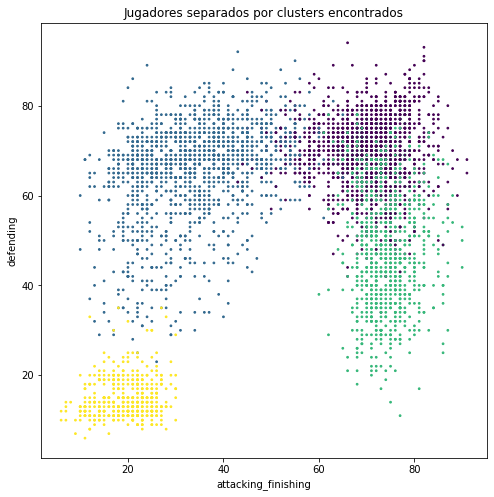

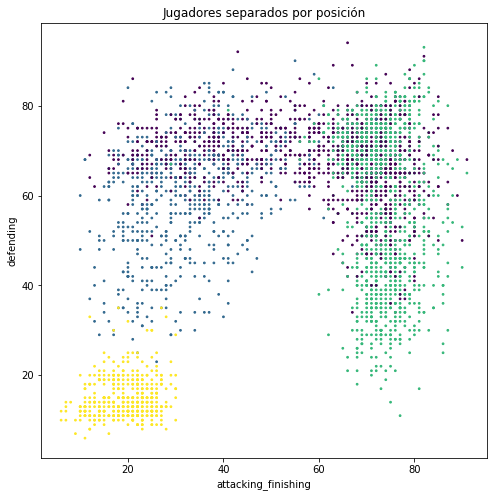

In [54]:
skill_1, skill_2 = "mentality_interceptions", "attacking_crossing"
plt.figure(figsize=(8,8))
plt.scatter(df_clusters[skill_1], y=df_clusters[skill_2], s=3, c=df_clusters['kmeans'])
plt.xlabel('attacking_finishing')
plt.ylabel('defending')
plt.title("Jugadores separados por clusters encontrados")
plt.show()

codes = {'Arquero':3, 'Defensor':2, 'Mediocampista':0, 'Delantero':1}

df_clusters['position_nro'] = df_clusters['position'].map(codes)

plt.figure(figsize=(8,8))
plt.scatter(
    df_clusters[skill_1], 
    y=df_clusters[skill_2], 
    s=3, 
    c=df_clusters['position_nro']
)
plt.xlabel('attacking_finishing')
plt.ylabel('defending')
plt.title("Jugadores separados por posición")
plt.show()

##### Observaciones
- Vemos cómo los clusters encontrados se corresponden fuertemente con la posición del jugador!
- Usando las variables de habilidades seleccionadas anteriormente, pero agrupando por clústers en lugar de las posiciones o la crackitud, podemos ver los grupos más diferenciados.
- En el primer gráfico usamos sólo las posiciones para separar los grupos. En cambio, k-means usa las variables seleccionadas de los skills para diferenciar los grupos lo cual incrementa mucho más la presicion.



Graficamos un plot HeatMap para ver la relación entre los clústers obtenidos y la variable posición creada. 
Dada la relación recién advertida, realizamos dos heatmaps entre las variables mencionadas para ver el comportamiento en filas y columnas.

(array([0.5, 1.5, 2.5, 3.5, 4.5]), <a list of 5 Text major ticklabel objects>)

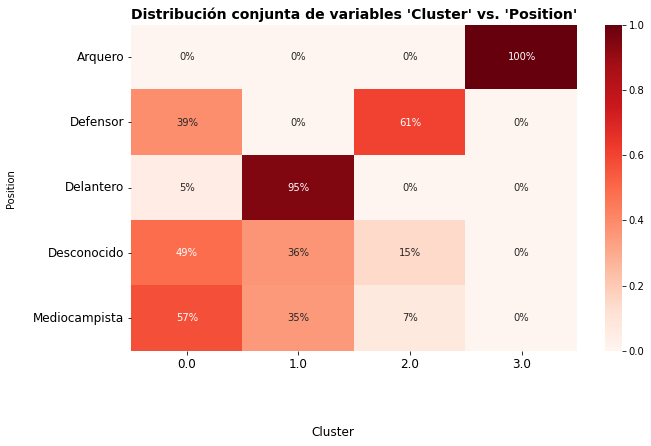

In [55]:
fig = plt.figure(figsize=(10,6))
exp = pd.crosstab(
    df_clusters['position'],
    df_clusters['kmeans'],
    normalize='index'
)
sns.heatmap(exp, annot=True, fmt='0.0%', cmap='Reds') #Greys
plt.yticks(rotation=0) 
plt.xlabel("")
plt.ylabel("Position \n")
plt.title("Distribución conjunta de variables 'Cluster' vs. 'Position'", fontsize=14, weight='bold')
plt.annotate(
    'Cluster', 
    xy=(0.5, -0.25), 
    xycoords='axes fraction', 
    ha='right', 
    va='center', 
    fontsize=12
)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

##### Observaciones
- Los arqueros se agruparon al 100% en un único cluster cuando utilizamos 4 grupos. Aquí se analiza el aglomeramiento obtenido sin los arqueros, es decir, 3 grupos.
- Los defensores se encuentran distribuidos entre el cluster 0 y el cluster 2, siendo mayoritariamente en el cluster 2.
- Los delanteros se encuentran casi en su totalidad en el cluster 1.
- Los mediocampistas se distribuyen en su mayoría entre el cluster 0 y el cluster 1 (mayormente en el cluster 0).


Con estos gráficos vemos una relación bastante estrecha entre la posición del jugador y los clústers encontrados en función de las `skills_ratings`.

### Algoritmo MeanShift

Realizamos ahora un aglomeramiento de jugadores basado en la densidad con la que se encuentran los puntos respecto de otros. 

Veamos cómo se comportan los datos teniendo en cuenta que los arqueros se ubican muy cerca entre sí mientras que el resto de los juagdores se encuentran de forma más dispersa.

Para determinar el número de clusters debemos obtener el mejor parámetro de bandwidth de acuerdo a la distribución de nuestros datos.

#### Todos los jugadores

Aglomeramos teniendo en cuenta a todos los jugadores, sin descartar a los arqueros.

In [56]:
bandwidth = estimate_bandwidth(X, quantile=0.3)
bandwidth

57.579967755422615

In [57]:
ms1 = MeanShift(bandwidth=30, bin_seeding=False, n_jobs=-1)
ms1.fit(X) 
n_clusters_all = len(np.unique(ms1.labels_))

print("Cantidad de clusters: %d" % n_clusters_all)

Cantidad de clusters: 3


Sabiendo que uno de los grupos aglomera a los arqueros, el bandwidth encontrado con `estimate_bandwith` no parece ser el correcto, ya que al aljustarse los datos se encuentran únicamente 2 clusters. Decidimos asignarle un bandwidth manualmente en base a lo observado.

#### Sin los arqueros

Ahora aglomeramos con el conjunto de datos sin los arqueros.

In [58]:
bandwidth = estimate_bandwidth(no_gk, quantile=0.5)
bandwidth

62.32767701210548

In [59]:
ms2 = MeanShift(bandwidth=30, bin_seeding=False, n_jobs=-1)
ms2.fit(no_gk) 
n_clusters_no_gk = len(np.unique(ms2.labels_))

print("Cantidad de clusters: %d" % n_clusters_no_gk)

Cantidad de clusters: 2


Sucede lo mismo que en el caso anterior, estimando el bandwidth se está encontrando un único cluster, por lo tanto, lo agregamos manualmente.

#### Analisis de silueta

Luego de realizar el aglomeramiento observamos algunas métricas. Como no es posible graficar todas las dimensiones, graficaremos con habilidades de a pares.

In [60]:
n_clust = n_clusters_all
cluster_labels = ms1.predict(X)
centers = ms1.cluster_centers_

Para n_clust = 3 El silhouette_score promedio es : 0.5517269974234179


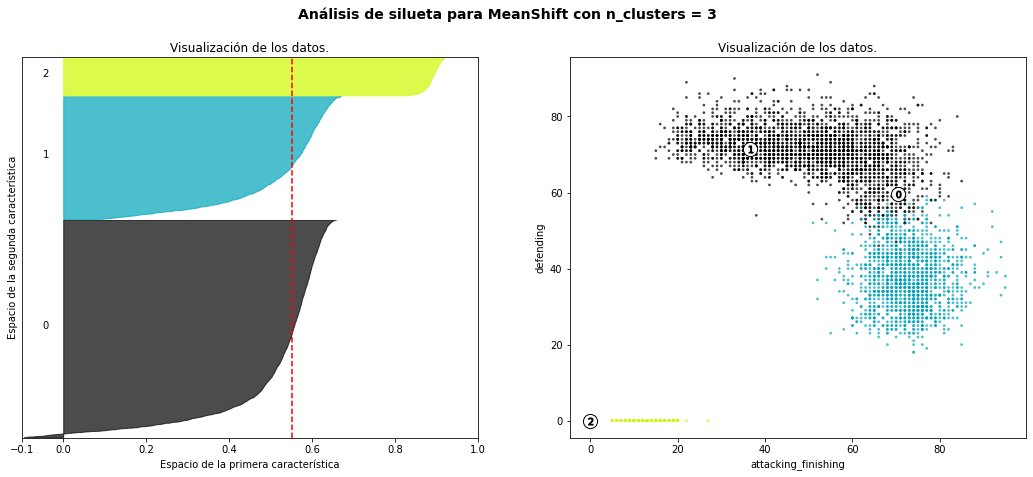

Para n_clust = 3 El silhouette_score promedio es : 0.5517269974234179


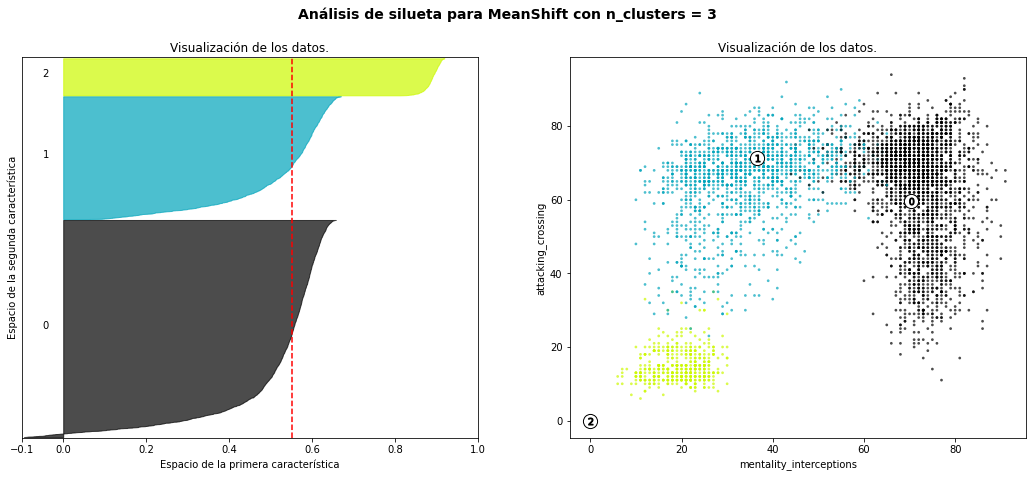

In [61]:
plot_silhouette("MeanShift", n_clust, cluster_labels, centers, X)

In [62]:
pd.Series(ms1.labels_).value_counts()

0    2598
1    1470
2     444
dtype: int64

##### Observaciones
- Los arqueros al encontrarse muy cerca entre parecen agruparse en un único cluster.
- El resto de los jugadores se encuentran bastante dispersos en el espacio, por lo cual se los agrupa en un segundo cluster. 

In [63]:
n_clust = n_clusters_no_gk
cluster_labels = ms2.predict(no_gk)
centers = ms2.cluster_centers_

Para n_clust = 2 El silhouette_score promedio es : 0.5150890399742808


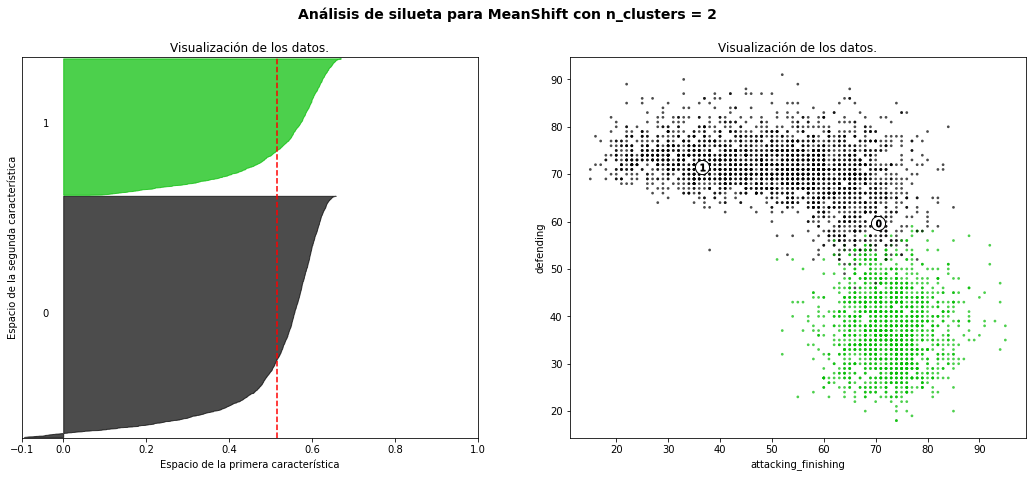

Para n_clust = 2 El silhouette_score promedio es : 0.5150890399742808


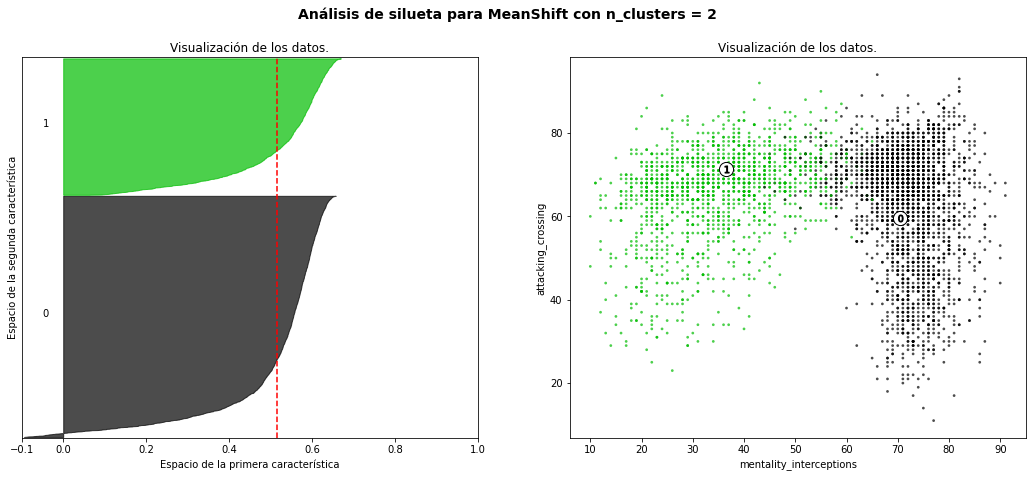

In [64]:
plot_silhouette("MeanShift", n_clust, cluster_labels, centers, no_gk)

#### Relación entre posición y clústers

Graficamos los clusters encontrados relacionándolo con la posición. Utilizamos el clustering de 3 sin arqueros ya que separa mejor al resto de los jugadores.



In [65]:
# Arqueros agregados al final para mantener los clusters
df_clusters = df_no_gk.copy()
df_clusters = df_clusters.append(df_gk, ignore_index=True)

# Agregamos las etiquetas faltantes de los arqueros 
all_labels = np.append(ms2.labels_, np.ones(len(df_gk)) * 3)
df_clusters['kmeans'] = all_labels

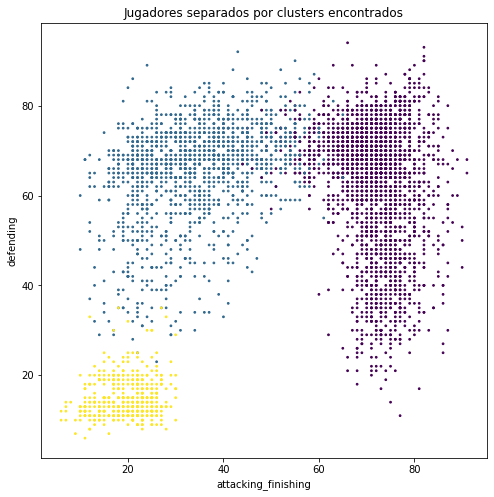

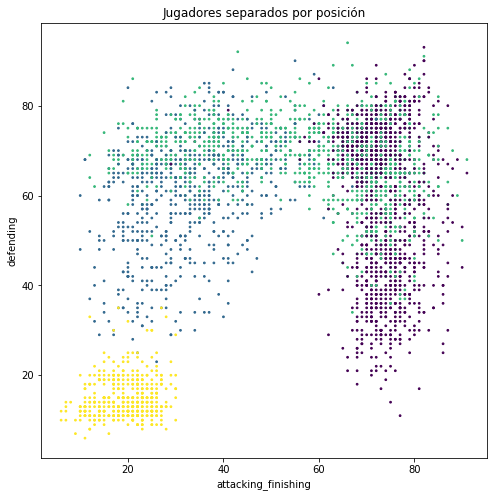

In [66]:
plt.figure(figsize=(8,8))
plt.scatter(df_clusters[skill_1], y=df_clusters[skill_2], s=3, c=df_clusters['kmeans'])
plt.xlabel('attacking_finishing')
plt.ylabel('defending')
plt.title("Jugadores separados por clusters encontrados")
plt.show()

codes = {'Arquero':3, 'Defensor':0, 'Mediocampista':2, 'Delantero':1}

df_clusters['position_nro'] = df_clusters['position'].map(codes)

plt.figure(figsize=(8,8))
plt.scatter(
    df_clusters[skill_1], 
    y=df_clusters[skill_2], 
    s=3, 
    c=df_clusters['position_nro']
)
plt.xlabel('attacking_finishing')
plt.ylabel('defending')
plt.title("Jugadores separados por posición")
plt.show()

##### Observaciones
- Vemos que en general se encuentran menos clusters que lo que observamos en Kmedias. Parece bastante acertado ya que se puede ver una separación aún mejor de los datos.
- Si bien en un principio intentamos dividir las posiciones en 4 y no 3, con MeanShift vemos que es correcto también agrupar en 3 clusters.
- Este algoritmo hace un mejor trabajo en la separación de jugadores que atacan y que defienden, quedando los mediocampistas dsitribuidos en ambos grupos. Esto tiene sentido ya que los mediocampitas se encuentran bastante dispersos en el espacio.

### Algoritmo Jerárquico

Ahora utilizaremos un método jerárquico para encontrar nuevas agrupaciones. Queremos ver cómo se comporta el método sabiendo que los arqueros se encuentran relativamente cerca entre ellos en el espacio (es un grupo más homogéneo) y están a una distancia mayor del resto de los jugadores, mientras que los no arqueros no son un grupo tan homogéneo sino que pueden encontrarse subgrupos más difíciles de diferenciar (como vimos en los otros métodos: los medioampistas, delateros y defensores tienen ciertas características en común).

In [67]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph
from scipy.cluster.hierarchy import dendrogram

#### Todos los jugadores

Aglomeramos teniendo en cuenta a todos los jugadores, sin descartar a los arqueros, ya que no creemos que sea necesario esta división.

In [68]:
connectivity = kneighbors_graph(X, n_neighbors=10, include_self=False)

In [69]:
params = {
    "n_clusters": None,
    "dist_threshold": 200,
}
jera = AgglomerativeClustering(
          n_clusters=params['n_clusters'], 
          linkage="average", 
          connectivity=connectivity,
          affinity='cityblock',
          distance_threshold=params['dist_threshold']
)
jera.fit(X)

AgglomerativeClustering(affinity='cityblock',
                        connectivity=<4512x4512 sparse matrix of type '<class 'numpy.float64'>'
	with 45120 stored elements in Compressed Sparse Row format>,
                        distance_threshold=200, linkage='average',
                        n_clusters=None)

Observamos el dendograma para determinar mejor los hiperparámetros.

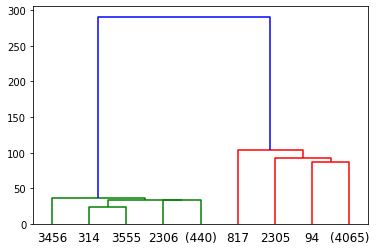

In [70]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

plot_dendrogram(jera, truncate_mode='level', p=3)

En el dendrograma podemos ver una separacion clara en dos grupos que creemos que pueden ser arqueros y no arqueros. Por otro lado, bajando un nivel en el grupo de color rojo, podemos identificar, a su vez, dos subgrupos: quizás defensores y delanteros. Los mediocampistas podrían estar distribuidos entre estos dos grupos. Podrían existir otras interpretaciones de las posibles jerarquías encontradas.

In [71]:
df_clusters = df_n.copy()
df_clusters['jera'] = jera.labels_ #clusters
print('AgglomerativeClustering encontró: ', max(jera.labels_)+1, 'clusters')

AgglomerativeClustering encontró:  2 clusters


Vemos que se obtienen 2 grupos con este método.

In [72]:
df_clusters['jera'].value_counts()

0    4068
1     444
Name: jera, dtype: int64

In [73]:
#P/Gráfico 2
skill_1 = 'attacking_finishing'
skill_2 = 'defending'

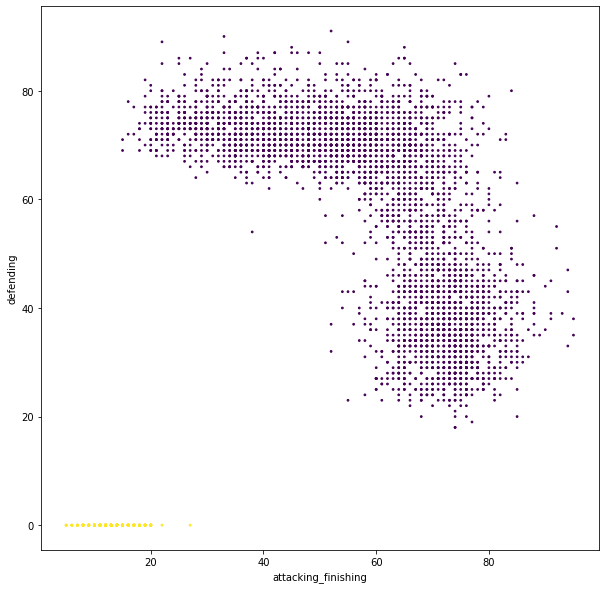

In [74]:
plt.figure(figsize=(10,10))
plt.scatter(df_clusters[skill_1], y=df_clusters[skill_2], s=3, c=df_clusters['jera'])#, alpha=0.2)
plt.xlabel(skill_1)
plt.ylabel(skill_2)
plt.show()

##### Observaciones
- Vemos que para este método y con estos parámetros resulta más adecuado separar entre arqueros y no arqueros, ya que ambos grupos mantienen una distancia bastante grande.
- Los no arqueros están muy mezclados y dispersos como para obterner buenos resultados con este método. Para esto quizás sea necesario bajar el umbral de distancia puesta como parámetro para lograr una mayor cantidad de clusters.

## 5. Embeddings y técnicas de clustering

Visualizamos las habilidades de los jugadores usando embeddings TSNE y PCA.

#### TSNE

In [75]:
tsne = TSNE(n_components=2, verbose=1,perplexity=30, n_iter=1000, init='random', random_state = 15)

In [76]:
df_tsne_all = tsne.fit_transform(df_n[specific_skills].fillna(0))

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 4512 samples in 0.000s...
[t-SNE] Computed neighbors for 4512 samples in 0.603s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4512
[t-SNE] Computed conditional probabilities for sample 2000 / 4512
[t-SNE] Computed conditional probabilities for sample 3000 / 4512
[t-SNE] Computed conditional probabilities for sample 4000 / 4512
[t-SNE] Computed conditional probabilities for sample 4512 / 4512
[t-SNE] Mean sigma: 14.289801
[t-SNE] KL divergence after 250 iterations with early exaggeration: 75.072693
[t-SNE] KL divergence after 1000 iterations: 1.780899


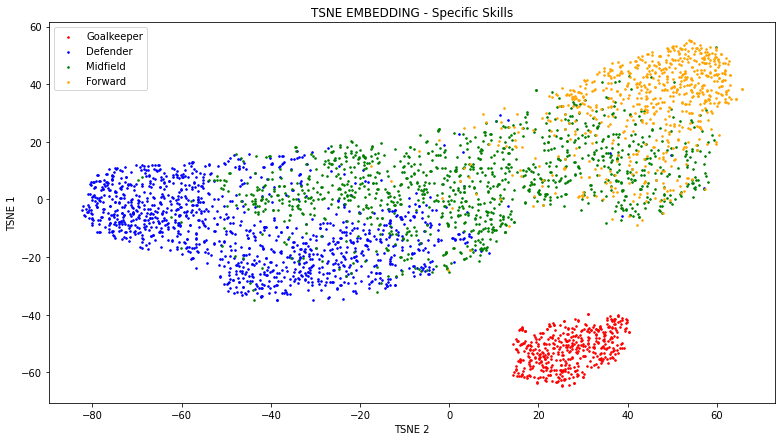

In [78]:
# Plot de resultado en 2 dimensiones
plt.figure(figsize=(13, 7))
plt.ylabel('TSNE 1')
plt.xlabel('TSNE 2')
plt.title('TSNE EMBEDDING - Specific Skills')
plt.scatter(df_tsne_all[df_n[df_n["position"] == "Arquero"].index][:,0], 
                      df_tsne_all[df_n[df_n["position"] == "Arquero"].index][:,1], s=2.5, 
                      c='red',
                      label='Goalkeeper')
plt.scatter(df_tsne_all[df_n[df_n["position"] == "Defensor"].index][:,0], 
                      df_tsne_all[df_n[df_n["position"] == "Defensor"].index][:,1], s=2.5, 
                      c='blue',
                      label='Defender')
plt.scatter(df_tsne_all[df_n[df_n["position"] == "Mediocampista"].index][:,0], 
                      df_tsne_all[df_n[df_n["position"] == "Mediocampista"].index][:,1], s=2.5, 
                      c='green',
                      label='Midfield')
plt.scatter(df_tsne_all[df_n[df_n["position"] == "Delantero"].index][:,0], 
                      df_tsne_all[df_n[df_n["position"] == "Delantero"].index][:,1], s=2.5, 
                      c='orange',
                      label='Forward')
plt.legend()

En este grafico las variables resultantes de TSNE son los ejes X e Y. Los puntos (jugadores) estan coloreados segun la variable posición. 

Se obtiene una conclusión similar a lo que se observo cuando utilizamos como ejes a attacking_finishing y defending, pero en este caso, tenemos la ventaja de que estas dos variables representan a todas las habilidades. 

#### PCA

En esta instancia, decidimos agrupar 4 variables en 2, usando PCA. Se muestran los resultados a continuación, donde posiblemente se puedan ver dos o tres grupos. Sin embargo, a diferencia de los gráficos realizados en el punto 2, se pierde la interpretabilidad al usar este metodo.

In [79]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3) 
X_new = pca.fit_transform(X.values)

In [80]:
codes = {'Arquero':3, 'Defensor':0, 'Mediocampista':2, 'Delantero':1}
df_n['position_nro'] = df_n['position'].map(codes)

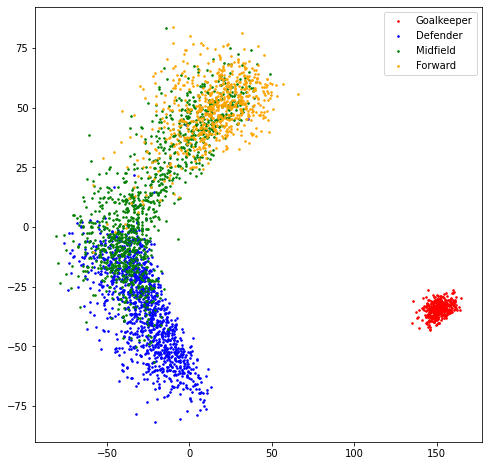

In [81]:
plt.figure(figsize=(8,8))
plt.scatter(X_new[df_n[df_n["position"] == "Arquero"].index][:,0], 
                      X_new[df_n[df_n["position"] == "Arquero"].index][:,1], s=2.5, 
                      c='red',
                      label='Goalkeeper')
plt.scatter(X_new[df_n[df_n["position"] == "Defensor"].index][:,0], 
                      X_new[df_n[df_n["position"] == "Defensor"].index][:,1], s=2.5, 
                      c='blue',
                      label='Defender')
plt.scatter(X_new[df_n[df_n["position"] == "Mediocampista"].index][:,0], 
                      X_new[df_n[df_n["position"] == "Mediocampista"].index][:,1], s=2.5, 
                      c='green',
                      label='Midfield')
plt.scatter(X_new[df_n[df_n["position"] == "Delantero"].index][:,0], 
                      X_new[df_n[df_n["position"] == "Delantero"].index][:,1], s=2.5, 
                      c='orange',
                      label='Forward')
plt.legend()

Se ve bastante clara la separación entre arqueros y no arqueros. De forma similar al TSNE se puede ver cómo "se separan" las posiciones dentro de los no arqueros: Forward (Delanteros), Midfield (Mediocampistas) y Defender (Defensores).

## 6. Evaluación

Como conclusión general, encontramos que la cantidad optima de clusters está entre 3 y 4. Realizamos una evaluacion comparando en distintos lugares de esta notebook las etiquetas de cluster con la etiqueta creada de la posicion del jugador. Concluimos que esta ultima tiene mucha influencia en dicha agrupación, lo cual es coherente con lo esperado para este dataset. 

Los arqueros pudieron diferenciarse desde el principio, y fueron útiles durante la exploración de los distintos grupos obtenidos en cada algoritmo de clustering.

En los tres metodos de clusters usamos las variables de habilidades. Teniendo en cuenta la relacion anterior entre posicion y etiqueta de cluster, vemos que los metodos logran concentrar la informacion de las habilidades de una manera que no se puede observar graficamente de forma bivariada. Esto se posibilita al utilizar los distintos métodos de embeddings. 

Para finalizar, la decisión sobre definir si son 3 o 4 clusters conlleva considerar la separación de los mediocampistas del resto de los jugadores. 

## 7. ¿Se realizo alguna normalización de la base?

- No se normalizaron los datos ya que todos están en la misma escala [0, 100] y por lo tanto no es necesario aplicar este método.

## Conclusión

Al finalizar el trabajo logramos encontrar clusters que resultan interpretables y acordes a lo previsto tanto para el equipo como para los expertos de dominio consultados.

Vemos la importancia de decidir correctamente un algoritmo u otro dependiendo de la distribución de los datos en el espacio. Además, la incorporación del jugador perfecto al dataset para el análisis facilitó la interpretabilidad del espacio graficado.